# Ouput and Parameter Norm: Deep Q-Network for CartPole

## Abstract

In this notebook we will introduce output and parameter norm tracking. We will train a deep Q-network for CartPole from gymnasium library.

## Imports and Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

RND_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
env = gym.make("CartPole-v1")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

## Output Norm Lens

``OutputNorm`` is a lens that provides functionality to track output norm on every forward pass. By default it skips passes made with ``torch.no_grad``, this behaviour can be tweaked by ``skip_no_grad_pass`` initialization argument.

Default configuation keeps track of all activations functions, one could add or exclude certain module classes using ``include`` and ``exclude`` parameters. 

For ease of comparison the lens allows to normalize outputs by square root of number of elements in the tensor, that way one could coprehend rough magnitudes of standalone neuron outputs.

## Parameter Norm Lens

``ParameterNorm`` lens allows to keep track of L2-norms or RMS of parameters on every tick of an epoch i.e. ``inspector.tick_epoch()``. If norms must be calculated more often lens provides a public ``collect()`` method to aggregate norm data.

The lens keeps track of parameters provided during initialization, for module to be tracked it must have all of the listed parameters.

As well as ``OutputNorm``, parameter norms can be normalized by square root of number of elements.


Both lenses can draw comparison plots to give the relationship between layers in one single window.


In [3]:
from monitorch.inspector import PyTorchInspector
from monitorch.lens import LossMetrics, OutputNorm, ParameterNorm

loss_fn = nn.MSELoss()

inspector = PyTorchInspector(
    lenses = [
        LossMetrics(
            loss_fn=loss_fn,
            metrics=['total_reward', 'smoothed_treward']
        ),
        OutputNorm(include=[nn.Identity], normalize_by_size=True),
        ParameterNorm(normalize_by_size=True)
    ]
)

## CartPole

We will implement a DQN algorithm with 4-layer neural network defined below.

In [4]:
from collections import OrderedDict

class QNetwork(nn.Module):

    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(OrderedDict([
            ('lin1',  nn.Linear(state_dim, 128)),
            ('relu1', nn.ReLU()),
            
            ('lin2',  nn.Linear(128, 128)),
            ('relu2', nn.ReLU()),
            
            ('lin3',  nn.Linear(128, 128)),
            ('relu3', nn.ReLU()),
            
            ('lin4',  nn.Linear(128, 128)),
            ('relu4', nn.ReLU()),

            ('lin_out', nn.Linear(128, action_dim)),
            ('output',  nn.Identity())
        ]))

    def forward(self, X):
        return self.net(X)

Here we define a replay buffer for the algorithm to save episode data into and for the network data to learn from.

In [5]:
from collections import deque, namedtuple

Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

In [6]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

Now we will train Q-network for 300 episodes with decaying epsilon greedy action selection. Our buffer will have 20000 memory slots.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [03:33<00:00,  1.40it/s]


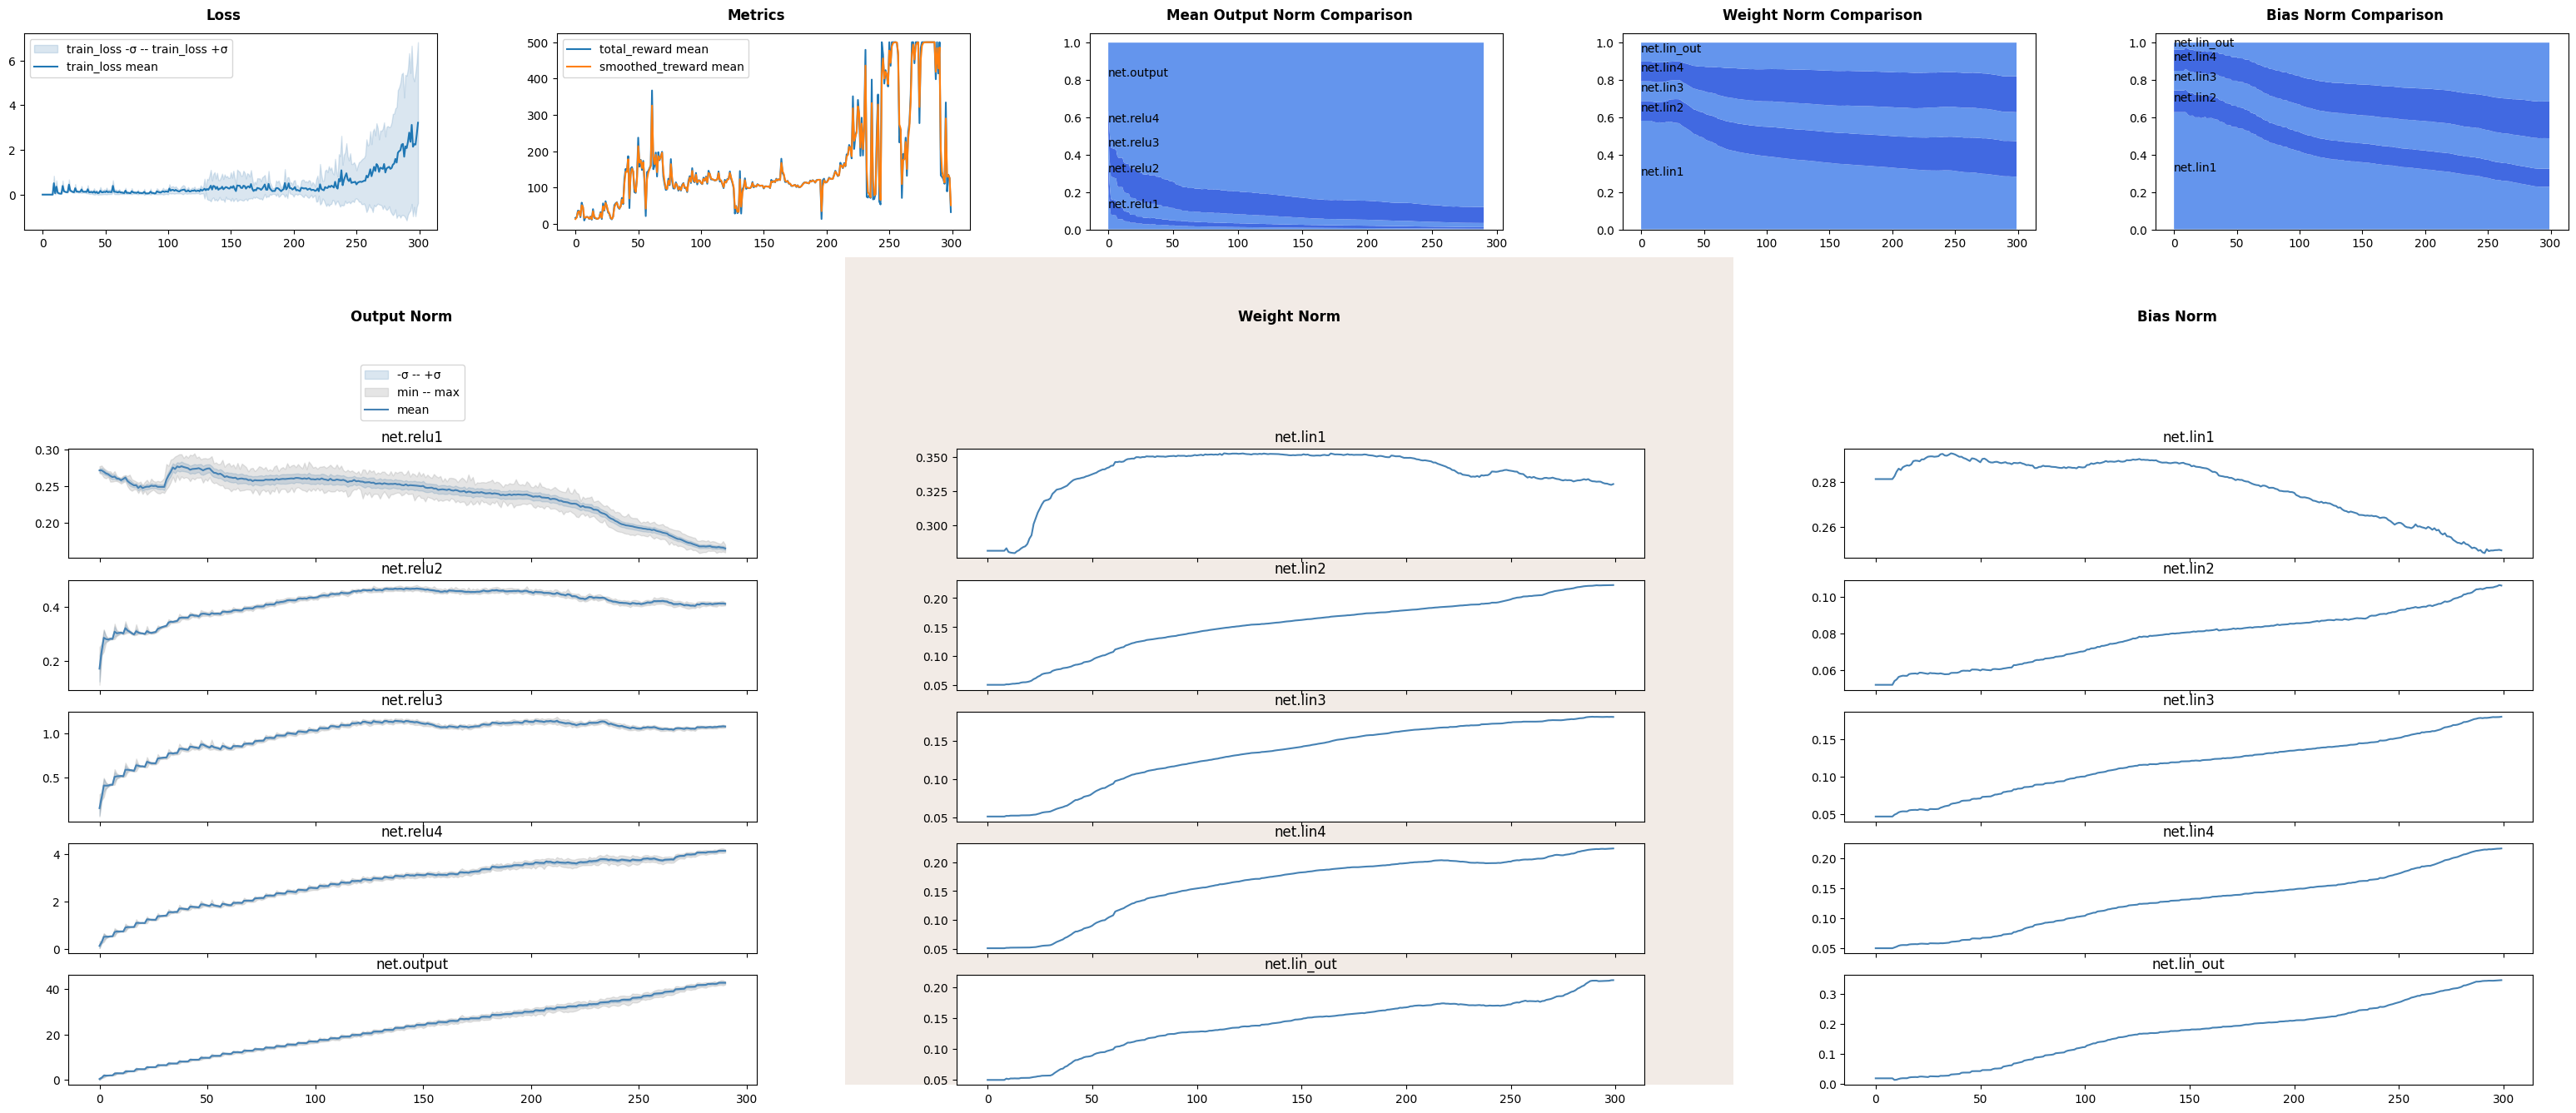

In [7]:
import warnings
import random
from tqdm import trange

warnings.simplefilter('ignore')

policy_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

inspector.attach(policy_net)
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=1e-3)

buffer = ReplayBuffer(20000)
BATCH_SIZE = 256

gamma = 0.99
eps_start, eps_end, eps_decay = 1.0, 0.05, 1000

steps_done = 0
N_EPISODES = 300
smoothing_factor = 0.2
smoothed_treward = 0
for episode in trange(N_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    total_reward = 0

    for t in range(500):
        # Epsilon-greedy action
        eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1. * steps_done / eps_decay)
        steps_done += 1
        if random.random() < eps_threshold:
            action = torch.tensor([[random.randrange(action_dim)]], dtype=torch.long)
        else:
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax(dim=1, keepdim=True)

        # Step environment
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        done = terminated or truncated
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        buffer.push(state, action, reward, next_state, done)
        state = next_state

        # Optimize
        if len(buffer) > BATCH_SIZE:
            transitions = buffer.sample(BATCH_SIZE)
            batch = Transition(*transitions)

            non_final_mask = ~torch.tensor(batch.done, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s, d in zip(batch.next_state, batch.done) if not d])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32)

            q_values = policy_net(state_batch).gather(1, action_batch)

            next_q_values = torch.zeros(BATCH_SIZE)
            with torch.no_grad():
                next_q_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

            expected_q_values = reward_batch + gamma * next_q_values
            loss = loss_fn(q_values.squeeze(), expected_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if done:
            break

    smoothed_treward = (1 - smoothing_factor)* total_reward + smoothing_factor * smoothed_treward
    inspector.push_metric('total_reward', total_reward)
    inspector.push_metric('smoothed_treward', smoothed_treward)
    inspector.tick_epoch()

    # Update target network
    if episode % 5 == 0:
        target_net.load_state_dict(policy_net.state_dict())
fig = inspector.visualizer.show_fig()

We see jagged corners at every fifth episode, when target network was update and neural network needed to learn a new landscape, outputs are domintated by output layer, as it is an estimation of utility function and has the largest values accross network.

## What to Look for

* Spikes of norms may signal gradient issues.
* Classification tasks usually lead to values near zero, thus norm will be small, while regression task as a Q-learning should gradually increase or decrease output norms and parameters norms to match target magnitude.

## Next Steps

* Take a look at other demonstration notebooks and documentation.
* Experiment with other RL environments and algortithm such as policy-gradient improvment to investigate norm development.